In [1]:
# Load modules
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import pandas as pd
from train_ann_functions import AsuSharedNN, ll, normaliser_shared
import matplotlib.pyplot as plt

In [2]:
# Load data
data_train = pd.read_csv('data/data_rum_4_train.csv')
data_test = pd.read_csv('data/data_rum_4_test.csv')

In [3]:
# Set scalars
J = 3
K = 2

# Set variables
Xvars = ['TRAIN_COST','TRAIN_TT','SM_COST','SM_TT','CAR_COST','CAR_TT']
X_train = data_train[Xvars]
X_test = data_test[Xvars]
X = pd.concat([X_train,X_test],axis=0)

transformer = normaliser_shared(X_shared = [1,0,1,0,1,0],shared_locations = [[0,2,4]])
transformer.fit(X)

X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)
X = transformer.transform(X)

y_train = data_train['CHOICE'].to_numpy() - 1
y_test = data_test['CHOICE'].to_numpy() - 1
y = np.r_[y_train,y_test]

In [4]:
# Select number of trainings and topologies
R = 10
network_topologies = [(5,),(6,),(7,),(8,),(9,),(10,),(15,),(20,),(30,),(5,5),(10,10),(20,20),(30,30)]

In [5]:
# Save results
t_list = []
lfull_list = []
ltest_list = []
r2_list = []
# Loop among topologies and repetitions

for t in network_topologies:
    for r in range(R):

        # Set model
        model = AsuSharedNN(topology=t,activation='tanh',from_logits=False)
        model.fit(X_train,y_train,[1,1,2,2,3,3],[1,0,1,0,1,0],early_stopping=True,validation_split=0.1)
        # Get log-likelihood
        ll_full = ll(y,model.predict_proba(X))
        ll_test = ll(y_test,model.predict_proba(X_test))
        r2_test = 1-ll_test/(len(X_test)*np.log(1/J))

        # Store current ll and topology
        t_list.append(str(t))
        lfull_list.append(ll_full)
        ltest_list.append(ll_test)
        r2_list.append(r2_test)
        print('NN ' + str(t) + ' / Rep. ' + str(r+1) + ': LL (full) = ' + str(round(ll_full,2))  + ' / LL (test) = ' + str(round(ll_test,2)) + ' / Rho-sq (test): ' + str(round(r2_test,4)))

NN (5,) / Rep. 1: LL (full) = -4513.03 / LL (test) = -933.42 / Rho-sq (test): 0.5301
NN (5,) / Rep. 2: LL (full) = -4520.39 / LL (test) = -934.38 / Rho-sq (test): 0.5296
NN (5,) / Rep. 3: LL (full) = -4525.07 / LL (test) = -935.42 / Rho-sq (test): 0.5291
NN (5,) / Rep. 4: LL (full) = -4523.93 / LL (test) = -935.61 / Rho-sq (test): 0.529
NN (5,) / Rep. 5: LL (full) = -4547.67 / LL (test) = -938.01 / Rho-sq (test): 0.5278
NN (5,) / Rep. 6: LL (full) = -4541.2 / LL (test) = -937.58 / Rho-sq (test): 0.528
NN (5,) / Rep. 7: LL (full) = -4509.86 / LL (test) = -932.82 / Rho-sq (test): 0.5304
NN (5,) / Rep. 8: LL (full) = -4540.72 / LL (test) = -937.79 / Rho-sq (test): 0.5279
NN (5,) / Rep. 9: LL (full) = -4536.51 / LL (test) = -937.04 / Rho-sq (test): 0.5282
NN (5,) / Rep. 10: LL (full) = -4569.81 / LL (test) = -942.5 / Rho-sq (test): 0.5255
NN (6,) / Rep. 1: LL (full) = -4531.59 / LL (test) = -935.96 / Rho-sq (test): 0.5288
NN (6,) / Rep. 2: LL (full) = -4535.84 / LL (test) = -936.93 / Rho-s

In [6]:
results = pd.DataFrame(np.c_[t_list,lfull_list,ltest_list],columns=['Topology','LL (full)','LL (test)'])
results.to_csv('tables/topology_4_asushared.csv')

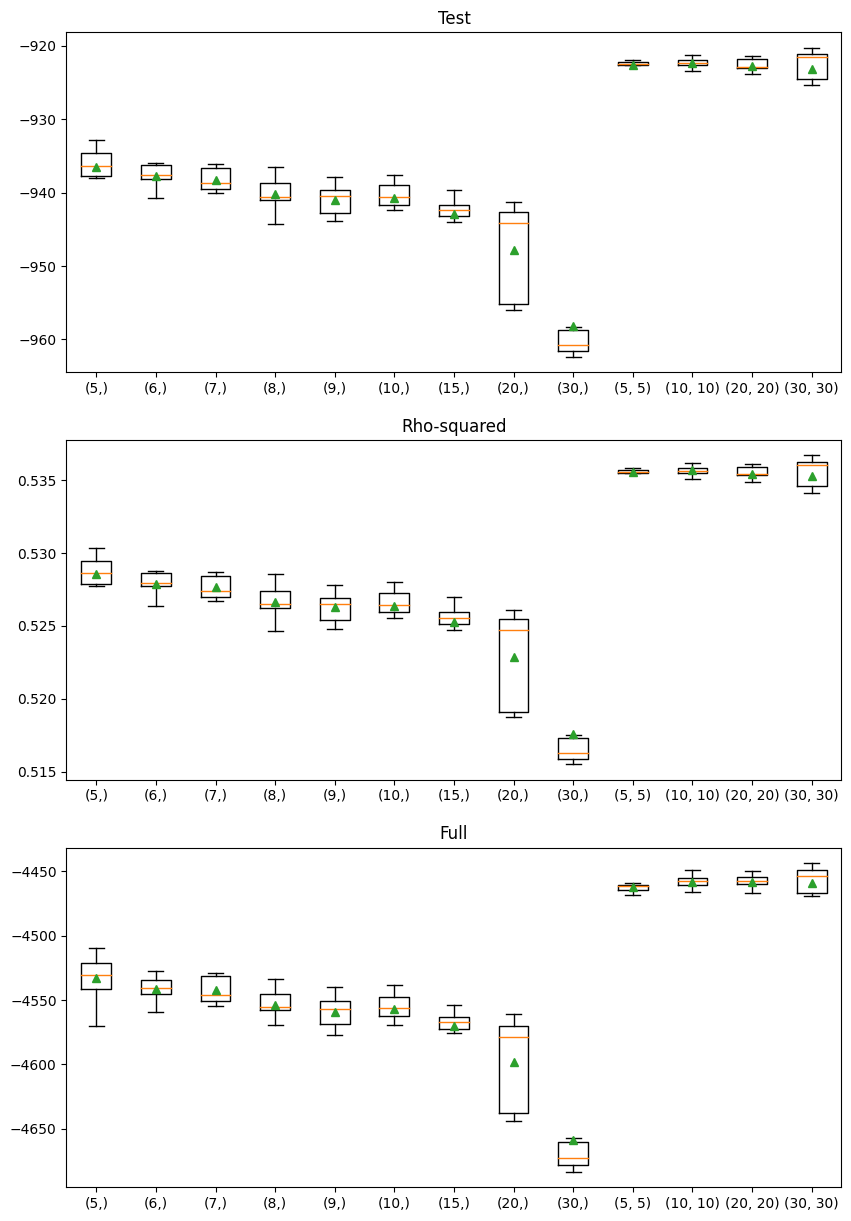

In [7]:
ll_test_df = pd.DataFrame(np.array(ltest_list).reshape((len(network_topologies),R)).T,columns=network_topologies)
r2_df = pd.DataFrame(np.array(r2_list).reshape((len(network_topologies),R)).T,columns=network_topologies)
ll_full_df = pd.DataFrame(np.array(lfull_list).reshape((len(network_topologies),R)).T,columns=network_topologies)

fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10,15))

ax1.boxplot(ll_test_df,showfliers=False,showmeans=True,labels=ll_test_df.columns)
ax1.set_title('Test')

ax2.boxplot(r2_df,showfliers=False,showmeans=True,labels=r2_df.columns)
ax2.set_title('Rho-squared')

ax3.boxplot(ll_full_df,showfliers=False,showmeans=True,labels=ll_full_df.columns)
ax3.set_title('Full')

plt.show()